# Coursework 2: Image segmentation

In this coursework you will develop and train a convolutional neural network for brain tumour image segmentation. Please read both the text and the code in this notebook to get an idea what you are expected to implement. Pay attention to the missing code blocks that look like this:

```
### Insert your code ###
...
### End of your code ###
```

## What to do?

* Complete and run the code using `jupyter-lab` or `jupyter-notebook` to get the results.

* Export (File | Save and Export Notebook As...) the notebook as a PDF file, which contains your code, results and answers, and upload the PDF file onto [Scientia](https://scientia.doc.ic.ac.uk).

* Instead of clicking the Export button, you can also run the following command instead: `jupyter nbconvert coursework.ipynb --to pdf`

* If Jupyter complains about some problems in exporting, it is likely that pandoc (https://pandoc.org/installing.html) or latex is not installed, or their paths have not been included. You can install the relevant libraries and retry.

* If Jupyter-lab does not work for you at the end, you can use Google Colab to write the code and export the PDF file.

## Dependencies

You need to install Jupyter-Lab (https://jupyterlab.readthedocs.io/en/stable/getting_started/installation.html) and other libraries used in this coursework, such as by running the command:
`pip3 install [package_name]`

## GPU resource

The coursework is developed to be able to run on CPU, as all images have been pre-processed to be 2D and of a smaller size, compared to original 3D volumes.

However, to save training time, you may want to use GPU. In that case, you can run this notebook on Google Colab. On Google Colab, go to the menu, Runtime - Change runtime type, and select **GPU** as the hardware acceleartor. At the end, please still export everything and submit as a PDF file on Scientia.


In [151]:
# Import libraries
# These libraries should be sufficient for this tutorial.
# However, if any other library is needed, please install by yourself.
import tarfile
import imageio.v2 as imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import numpy as np
import time
import os
import random
import matplotlib.pyplot as plt
from matplotlib import colors

## 1. Download and visualise the imaging dataset.

The dataset is curated from the brain imaging dataset in [Medical Decathlon Challenge](http://medicaldecathlon.com/). To save the storage and reduce the computational cost for this tutorial, we extract 2D image slices from T1-Gd contrast enhanced 3D brain volumes and downsample the images.

The dataset consists of a training set and a test set. Each image is of dimension 120 x 120, with a corresponding label map of the same dimension. There are four number of classes in the label map:

- 0: background
- 1: edema
- 2: non-enhancing tumour
- 3: enhancing tumour

In [2]:
# Download the dataset
!wget https://www.dropbox.com/s/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz

# Unzip the '.tar.gz' file to the current directory
datafile = tarfile.open('Task01_BrainTumour_2D.tar.gz')
datafile.extractall()
datafile.close()

--2024-02-16 10:52:56--  https://www.dropbox.com/s/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.64.18
Connecting to www.dropbox.com (www.dropbox.com)|162.125.64.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz [following]
--2024-02-16 10:52:56--  https://www.dropbox.com/s/raw/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc84b7af8ee8511d47f43e0e4cbe.dl.dropboxusercontent.com/cd/0/inline/CNaIVfoInZkriKkq4nZ9vgdLEzJs4XWHweZMa_p6SPp5uAC8XOFQD5NFUfb37-ZXHo2WwL56g2zu9L4jjvBTV_QWwUQ9--ZfWjuLYiCoghNWchPmtXP13YDRhnB-QffkWYc/file# [following]
--2024-02-16 10:52:57--  https://uc84b7af8ee8511d47f43e0e4cbe.dl.dropboxusercontent.com/cd/0/inline/CNaIVfoInZkriKkq4nZ9vgdLEzJs4XWHweZMa_p6SPp5uAC8XOFQD5NFUfb37-ZXHo2WwL56g2zu9L4jjvBTV_QWwUQ9--ZfWjuLY

## Visualise a random set of 4 training images along with their label maps.

Suggested colour map for brain MR image:
```
cmap = 'gray'
```

Suggested colour map for segmentation map:
```
cmap = colors.ListedColormap(['black', 'green', 'blue', 'red'])
```

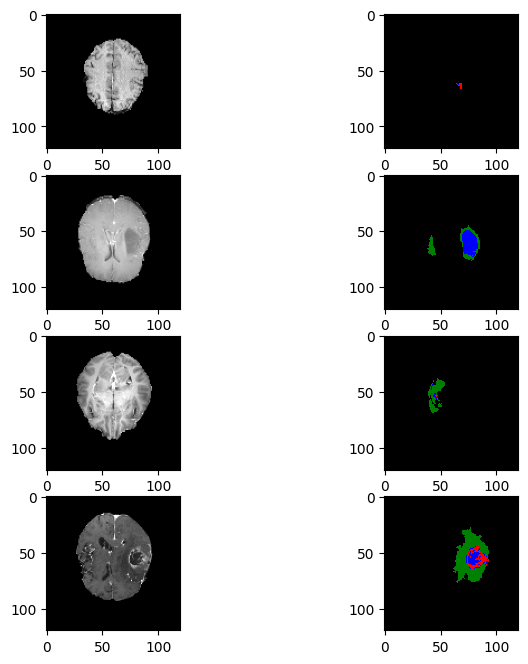

In [152]:
### Insert your code ###
def show_image_and_seg_map(fname, index = 1, rows = 4, path='Task01_BrainTumour_2D/training_'):
  image = imageio.imread(os.path.join(path + "images", fname))
  plt.subplot(rows, 2, index)
  plt.imshow(image, cmap='gray')
  seg_map = imageio.imread(os.path.join(path + "labels", fname))
  plt.subplot(rows, 2, index + 1)
  plt.imshow(seg_map, cmap = colors.ListedColormap(['black', 'green', 'blue', 'red']))
  plt.gcf().set_size_inches(8, 8)

for i in range(1, 8, 2):
  fname = random.choice(os.listdir('Task01_BrainTumour_2D/training_images/'))
  show_image_and_seg_map(fname, index = i)
### End of your code ###

## 2. Implement a dataset class.

It can read the imaging dataset and get items, pairs of images and label maps, as training batches.

In [153]:
def normalise_intensity(image, thres_roi=1.0):
    """ Normalise the image intensity by the mean and standard deviation """
    # ROI defines the image foreground
    val_l = np.percentile(image, thres_roi)
    roi = (image >= val_l)
    mu, sigma = np.mean(image[roi]), np.std(image[roi])
    eps = 1e-6
    image2 = (image - mu) / (sigma + eps)
    return image2


class BrainImageSet(Dataset):
    """ Brain image set """
    def __init__(self, image_path, label_path='', deploy=False):
        self.image_path = image_path
        self.deploy = deploy
        self.images = []
        self.labels = []

        image_names = sorted(os.listdir(image_path))
        for image_name in image_names:
            # Read the image
            image = imageio.imread(os.path.join(image_path, image_name))
            self.images += [image]

            # Read the label map
            if not self.deploy:
                label_name = os.path.join(label_path, image_name)
                label = imageio.imread(label_name)
                self.labels += [label]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get an image and perform intensity normalisation
        # Dimension: XY
        image = normalise_intensity(self.images[idx])

        # Get its label map
        # Dimension: XY
        label = self.labels[idx]
        return image, label

    def get_random_batch(self, batch_size):
        # Get a batch of paired images and label maps
        # Dimension of images: NCXY
        # Dimension of labels: NXY
        images, labels = [], []

        ### Insert your code ###
        indexes = random.choices(range(len(self.images)), k=batch_size)
        images = np.array([ self.images[i] for i in indexes ])
        labels = np.array([ self.labels[i] for i in indexes ])

        images = np.expand_dims(images, axis=1)
        ### End of your code ###
        return images, labels

## 3. Build a U-net architecture.

You will implement a U-net architecture. If you are not familiar with U-net, please read this paper:

[1] Olaf Ronneberger et al. [U-Net: Convolutional networks for biomedical image segmentation](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28). MICCAI, 2015.

For the first convolutional layer, you can start with 16 filters. We have implemented the encoder path. Please complete the decoder path.

In [154]:
""" U-net """
class UNet(nn.Module):
    def __init__(self, input_channel=1, output_channel=1, num_filter=16):
        super(UNet, self).__init__()

        # BatchNorm: by default during training this layer keeps running estimates
        # of its computed mean and variance, which are then used for normalization
        # during evaluation.

        # Encoder path
        n = num_filter  # 16
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channel, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 32
        self.conv2 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 64
        self.conv3 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 128
        self.conv4 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )
        
        # Decoder path
        ### Insert your code ###
        n = int(n / 2)  # 64
        self.up1 = nn.ConvTranspose2d(n * 2, n, kernel_size=2, stride=2)
        #self.up1 = nn.Upsample(scale_factor=2, mode="bilinear")
        self.conv5 = nn.Sequential(
            nn.Conv2d(n * 2, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n = int(n / 2)  # 32
        self.up2 = nn.ConvTranspose2d(n * 2, n, kernel_size=2, stride=2)
        self.conv6 = nn.Sequential(
            nn.Conv2d(n * 2, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n = int(n / 2)  # 16
        self.up3 = nn.ConvTranspose2d(n * 2, n, kernel_size=2, stride=2, padding=0)
        self.conv7 = nn.Sequential(
            nn.Conv2d(n * 2, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        self.conv8 = nn.Conv2d(n, output_channel, kernel_size=1)
        ### End of your code ###

    def forward(self, x):
        # Use the convolutional operators defined above to build the U-net
        # The encoder part is already done for you.
        # You need to complete the decoder part.
        # Encoder
        x = self.conv1(x)
        conv1_skip = x

        x = self.conv2(x)
        conv2_skip = x

        x = self.conv3(x)
        conv3_skip = x

        x = self.conv4(x)

        # Decoder
        ### Insert your code ###
        # up-conv 2x2
        x = self.up1(x)
        # concatenation with cropped feature map from contracting path
        x_concat = torch.cat([conv3_skip, x], dim=1)
        # 2 3x3 convs + ReLU
        x = self.conv5(x_concat)

        x = self.up2(x)
        x_concat = torch.cat([conv2_skip, x], dim=1)
        x = self.conv6(x_concat)

        x = self.up3(x)
        x_concat = torch.cat([conv1_skip, x], dim=1)
        x = self.conv7(x_concat)

        # output 1x1 conv
        x = self.conv8(x)
        ### End of your code ###
        return x

## 4. Train the segmentation model.

In [193]:
# CUDA device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {0}'.format(device))

# Build the model
num_class = 4
model = UNet(input_channel=1, output_channel=num_class, num_filter=16)
model = model.to(device)
params = list(model.parameters())

model_dir = 'saved_models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Optimizer
optimizer = optim.Adam(params, lr=1e-3)

# Segmentation loss
criterion = nn.CrossEntropyLoss()

# Datasets
train_set = BrainImageSet('Task01_BrainTumour_2D/training_images', 'Task01_BrainTumour_2D/training_labels')
test_set = BrainImageSet('Task01_BrainTumour_2D/test_images', 'Task01_BrainTumour_2D/test_labels')

# Train the model
# Note: when you debug the model, you may reduce the number of iterations or batch size to save time.
num_iter = 10000
train_batch_size = 16
eval_batch_size = 16
start = time.time()
for it in range(1, 1 + num_iter):
    # Set the modules in training mode, which will have effects on certain modules, e.g. dropout or batchnorm.
    start_iter = time.time()
    model.train()

    # Get a batch of images and labels
    images, labels = train_set.get_random_batch(train_batch_size)
    images, labels = torch.from_numpy(images), torch.from_numpy(labels)
    images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
    logits = model(images)

    # Perform optimisation and print out the training loss
    ### Insert your code ###
    loss = criterion(logits, labels)
    if it % 1000 == 0:
        print("Iteration:", it, "Training loss:", loss.item())
    model.zero_grad()
    loss.backward()
    optimizer.step()
    ### End of your code ###

    # Evaluate
    if it % 1000 == 0:
        model.eval()
        # Disabling gradient calculation during reference to reduce memory consumption
        with torch.no_grad():
            # Evaluate on a batch of test images and print out the test loss
            ### Insert your code ###
            images, labels = test_set.get_random_batch(eval_batch_size)
            images, labels = torch.from_numpy(images), torch.from_numpy(labels)
            images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
            logits = model(images)
            loss = criterion(logits, labels)
            print("Iteration:", it, "Eval loss:", loss.item())
            ### End of your code ###

    # Save the model
    if it % 5000 == 0:
        torch.save(model.state_dict(), os.path.join(model_dir, 'model_{0}.pt'.format(it)))
print('Training took {:.3f}s in total.'.format(time.time() - start))

Device: mps
Iteration: 1000 Training loss: 0.039234012365341187
Iteration: 1000 Eval loss: 0.04716052487492561
Iteration: 2000 Training loss: 0.025000864639878273
Iteration: 2000 Eval loss: 0.028817253187298775
Iteration: 3000 Training loss: 0.016422588378190994
Iteration: 3000 Eval loss: 0.029880661517381668
Iteration: 4000 Training loss: 0.021381773054599762
Iteration: 4000 Eval loss: 0.029909316450357437
Iteration: 5000 Training loss: 0.008198748342692852
Iteration: 5000 Eval loss: 0.04207438603043556
Iteration: 6000 Training loss: 0.0138644278049469
Iteration: 6000 Eval loss: 0.05710149183869362
Iteration: 7000 Training loss: 0.01342773251235485
Iteration: 7000 Eval loss: 0.032072409987449646
Iteration: 8000 Training loss: 0.01193808764219284
Iteration: 8000 Eval loss: 0.053148455917835236
Iteration: 9000 Training loss: 0.00804466474801302
Iteration: 9000 Eval loss: 0.06866949051618576
Iteration: 10000 Training loss: 0.009702188894152641
Iteration: 10000 Eval loss: 0.07313871383666

## 5. Deploy the trained model to a random set of 4 test images and visualise the automated segmentation.

You can show the images as a 4 x 3 panel. Each row shows one example, with the 3 columns being the test image, automated segmentation and ground truth segmentation.

Loss: 0.0899343341588974


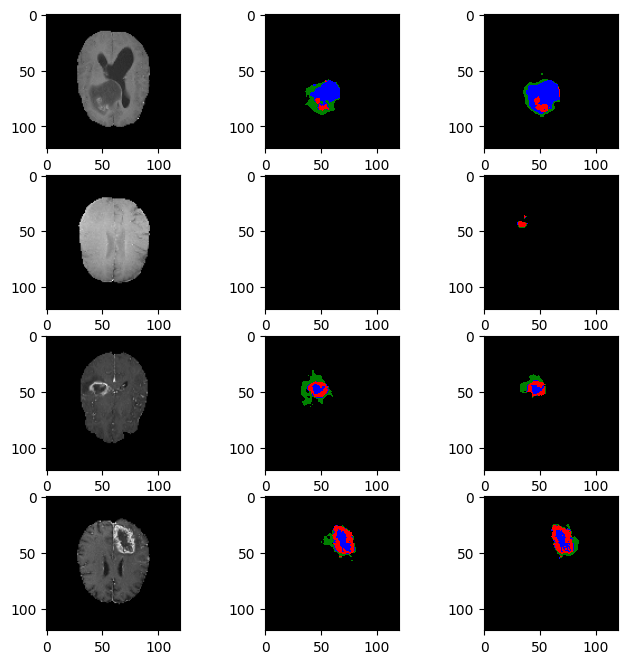

In [205]:
### Insert your code ###
# Get the most trained model
_iters, model_name = sorted([(int(name.split("_")[1].removesuffix(".pt")), name) 
                             for name in os.listdir(model_dir)])[-1]

# Run the model on 4 test images
model.load_state_dict(torch.load(os.path.join(model_dir, model_name)))
images, labels = test_set.get_random_batch(4)
images, labels = torch.from_numpy(images), torch.from_numpy(labels)
images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)

logits = model(images)

loss = criterion(logits, labels)
print("Loss:", loss.item())

for i, pred in enumerate(logits):
  image = np.squeeze(images[i].cpu())
  plt.subplot(4, 3, i * 3 + 1)
  plt.imshow(image, cmap='gray')

  pred_image = torch.argmax(pred.detach().cpu(), dim=0)
  plt.subplot(4, 3, i * 3 + 2)
  plt.imshow(pred_image, cmap = colors.ListedColormap(['black', 'green', 'blue', 'red']))

  label = labels[i].cpu()
  plt.subplot(4, 3, i * 3 + 3)
  plt.imshow(label, cmap = colors.ListedColormap(['black', 'green', 'blue', 'red']))
plt.gcf().set_size_inches(8, 8)
### End of your code ###

## 6. Discussion. Does your trained model work well? How would you improve this model so it can be deployed to the real clinic?

The model works reasonably well. After 10,000 training iterations it achieves a cross-entropy loss of 0.0731 on the test dataset. However, it seems that the model starts to overfit on the dataset after around 4,000 iterations (with eval loss of 0.0299) as the training loss continues to decrease, whereas the evalutaion loss increases. This overfitting could be combatted by using more training data or stopping the training process after ~4,000 iterations (See the output of the model after 5000 iterations in the cell below).

## Improvements

### Training Data
The model is trained with 2028 samples. Despite the U-Net architecture in general performing well for smaller datasets it would benefit from more samples and, as mentioned above, would combat overfitting. To produce more training samles we could augment the training samples. For example we could crop, rotate and transpose the images. We could also flip the images in the y-axis, but I would consult an expert on whether this may affect the data in an unexpected way as the human brain is asymmetric. 

### Cross-Validation
We could implement cross-validation in order to evaluate the model's performance during training more effectively. The current process of evaluating on a small batch of the test dataset is susceptible to noise as it is dependent on the randomly chosen samples.

### Thresholding
Before deploying the model in a real clinic, the model could be tuned to favor false positives that could then be send for human review. This could be done by favouring the classes 1, 2, 3 over class 0 when the model's confidence between classes is close. The amount of false positives that were produced by the model would have to be tuned in order to avoid missing tumor's but also not producing too many false positives that could lead to an overload for clinicians and make the automated system redundant.

### 3D Scans
As we are slicing the 3 dimensional scans into 2D images, a further improvement to the detection system could be made by passing all slices of a given 3D scan through the model and returning whether the classes 1, 2 or 3 where detected anywhere in the brain scan. This would lead to higher accuracy in detection as the areas of interest will most likely span multiple 2D slices so if one slice misses the tumor, another slice may detect it.


Loss: 0.041338756680488586


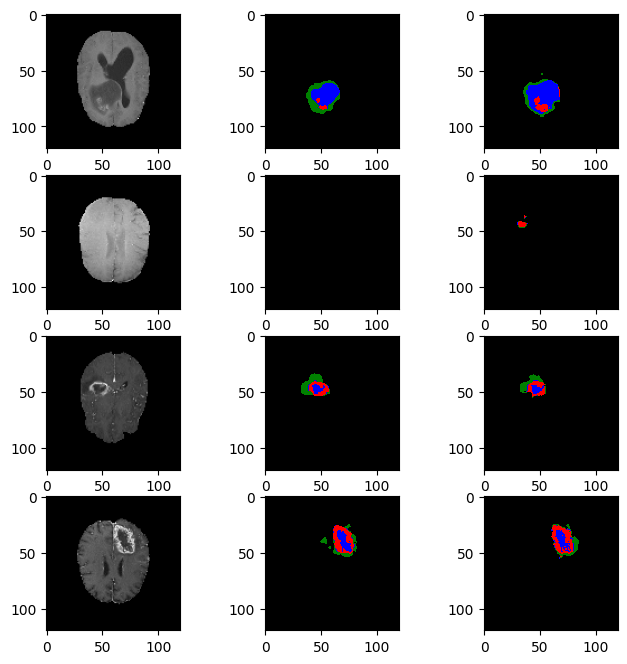

In [207]:
# Get the least trained model
_iters, model_name = sorted([(int(name.split("_")[1].removesuffix(".pt")), name) 
                             for name in os.listdir(model_dir)])[0]

# Run the model on 4 test images
model.load_state_dict(torch.load(os.path.join(model_dir, model_name)))

logits = model(images)

loss = criterion(logits, labels)
print("Loss:", loss.item())

for i, pred in enumerate(logits):
  image = np.squeeze(images[i].cpu())
  plt.subplot(4, 3, i * 3 + 1)
  plt.imshow(image, cmap='gray')

  pred_image = torch.argmax(pred.detach().cpu(), dim=0)
  plt.subplot(4, 3, i * 3 + 2)
  plt.imshow(pred_image, cmap = colors.ListedColormap(['black', 'green', 'blue', 'red']))

  label = labels[i].cpu()
  plt.subplot(4, 3, i * 3 + 3)
  plt.imshow(label, cmap = colors.ListedColormap(['black', 'green', 'blue', 'red']))
plt.gcf().set_size_inches(8, 8)